# RNN Sequence to Sequence Learning with Blocks and Fuel

## Setup

### Some basic imports

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import mpld3
mpld3.enable_notebook()

### Set default figure size

In [2]:
# default figure width and hight.
FIG_W = 10
FIG_H = 5
mpl.rcParams['figure.figsize'] = (FIG_W, FIG_H)

### Set Path for Output

In [3]:
from os import path
from dl_meetup.utils.file import safe_mkdir

OUTPUT_DIR = None
if OUTPUT_DIR is None:
    OUTPUT_DIR = path.join(
        path.expanduser('~'),
        'deep_learning_tutorial'
    )
safe_mkdir(OUTPUT_DIR)

Directory /home/andershuss/deep_learning_tutorial already exists, if you continue all data will be overwritten. Do you wish to continue? [y/n]y


## Source Separation Problem 

### SignalSampler

In [4]:
from dl_meetup.data.signal_sampler import Sine, Square, Line

In [5]:
n_time_steps = 200

In [6]:
sine_sampler = Sine(
    n_time_steps=n_time_steps,
    amplitude_range=(0.1, 1.0),
    period_range=(20, 50),
    phase_range=(0, 50)
)

In [7]:
sines = sine_sampler.samples(n_samples=5)

In [8]:
sines.shape # (S, T) = (n_samples, n_timesteps)

(5, 200)

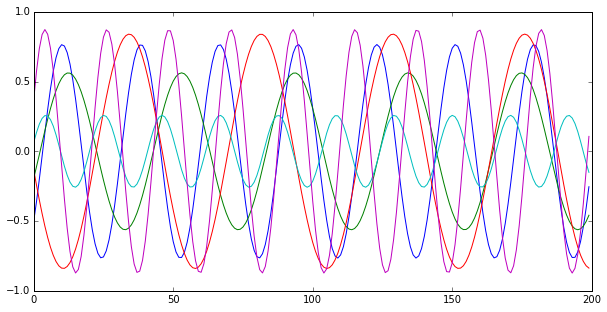

In [9]:
_ = plt.plot(sines.T)

In [10]:
square_sampler = Square(
    n_time_steps=n_time_steps,
    amplitude_range=(0.1, 1.0),
    off_duration_range=(10, 50),
    on_duration_range=(10, 50),
    duration_variation_range=(-5, 20)
)

In [11]:
squares = square_sampler.samples(n_samples=5)

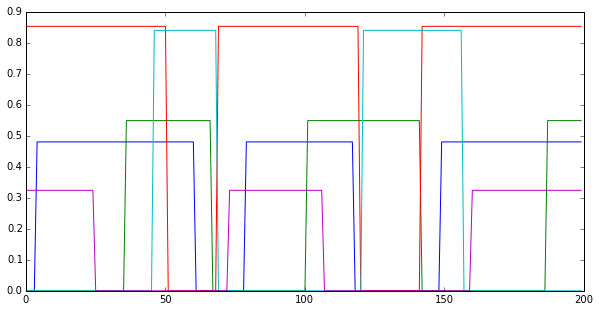

In [12]:
_ = plt.plot(squares.T)

## Generate Training Data

In [13]:
sine = Sine(
    n_time_steps=n_time_steps,
    amplitude_range=(0.2, 0.5),
    period_range=(30, 50),
    phase_range=(0, 25)
)
square = Square(
    n_time_steps=n_time_steps,
    amplitude_range=(0.5, 1.0),
    off_duration_range=(10, 20),
    on_duration_range=(10, 20),
    duration_variation_range=(-1, 1)
)
samplers = [sine, square]

In [14]:
n_training_samples = 1000

In [15]:
signals = map(
    lambda signal_sampler: signal_sampler.samples(
        n_samples=n_training_samples
    ),
    samplers
)
print('shape of signals = {}'.format(signals[0].shape))

shape of signals = (1000, 200)


### Dimensions

General format for (possibly multi dimensional) timeseries dataset:
(S, T, F) = $(N_{samples}, N_{timesteps}, N_{features})$

In [16]:
from dl_meetup.utils.convert import st1_of_st
signals_st1 = map(
    st1_of_st,
    signals
)
print('shape of signals_st1 = {}'.format(signals_st1[0].shape))

shape of signals_st1 = (1000, 200, 1)


In [17]:
target_data = np.concatenate(signals_st1, axis=2)
print('shape of target = {}'.format(target_data.shape))

shape of target = (1000, 200, 2)


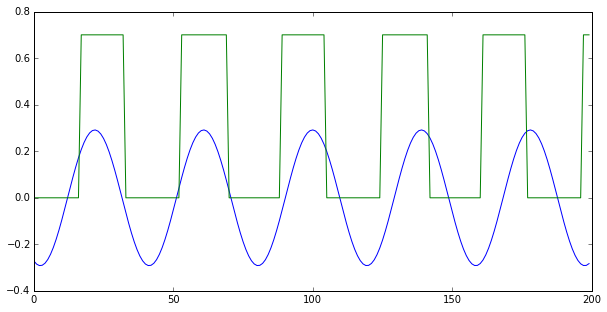

In [18]:
_ = plt.plot(target_data[1, :, :])

In [19]:
input_data = np.sum(target_data, axis=2, keepdims=True)
print('shape of input = {}'.format(input_data.shape))

shape of input = (1000, 200, 1)


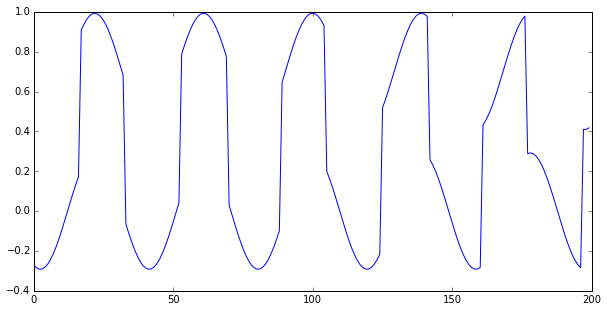

In [20]:
_ = plt.plot(input_data[1, :, :])

## Get Your Data Into a Fuel Datastream

In [21]:
from dl_meetup.data.to_h5py import write_h5py_dataset

DATA_DIR = path.join(
    OUTPUT_DIR,
    'data'
)
safe_mkdir(DATA_DIR)
DATA_DIR

'/home/andershuss/deep_learning_tutorial/data'

### Dataset 

In [22]:
from dl_meetup.data.to_h5py import write_h5py_dataset

training_data_file_path = path.join(
    DATA_DIR,
    'signals.hdf5'
)
training_validation_split_idx = 800

write_h5py_dataset(
    nested_dataset_dict={
        'training': {
            'input': input_data[:training_validation_split_idx],
            'target': target_data[:training_validation_split_idx]
        },
        'validation': {
            'input': input_data[training_validation_split_idx:],
            'target': target_data[training_validation_split_idx:]
        }
    },
    file_path=training_data_file_path,
    sources_dim_labels={
        'input': ('sample', 'time', '1'),
        'target': ('sample', 'time', 'signal')
    }
)

In [23]:
from fuel.datasets import H5PYDataset
from dl_meetup.data.to_h5py import h5py_dataset_summary

training_dataset = H5PYDataset(
    training_data_file_path,
    which_set='training',
    load_in_memory=True
)
validation_dataset = H5PYDataset(
    training_data_file_path,
    which_set='validation',
    load_in_memory=True
)
print(h5py_dataset_summary(training_dataset) + '\n')
print(h5py_dataset_summary(validation_dataset))

Dataset: training
sources: (u'input', u'target')
number of samples: 800

Dataset: validation
sources: (u'input', u'target')
number of samples: 200


### Datastream

In [24]:
from fuel.streams import DataStream
from fuel.schemes import ShuffledScheme

training_datastream = DataStream.default_stream(
    dataset=training_dataset,
    iteration_scheme=ShuffledScheme(
        examples=training_dataset.num_examples,
        batch_size=50
    )
)
validation_datastream = DataStream.default_stream(
    dataset=validation_dataset,
    iteration_scheme=ShuffledScheme(
        examples=validation_dataset.num_examples,
        batch_size=50
    )
)

In [25]:
epoch = training_datastream.get_epoch_iterator(as_dict=True)
batch = next(epoch)
batch.keys()
print('input batch shape: {}'.format(batch['input'].shape))
print('target batch shape: {}'.format(batch['target'].shape))

input batch shape: (50, 200, 1)
target batch shape: (50, 200, 2)


### Note: Dataformat for RNNs in Blocks  -  (T, S, F)

In [26]:
from dl_meetup.fuel_additions.transformers import (
    TSFFromSTF,
    ForceTheanoFloatX
)
apply_transfomrers = lambda stream: ForceTheanoFloatX(TSFFromSTF(stream))

training_datastream = apply_transfomrers(training_datastream)
validation_datastream = apply_transfomrers(validation_datastream)

In [27]:
epoch = training_datastream.get_epoch_iterator(as_dict=True)
batch = next(epoch)
batch.keys()
print('input batch shape: {}'.format(batch['input'].shape))
print('target batch shape: {}'.format(batch['target'].shape))

input batch shape: (200, 50, 1)
target batch shape: (200, 50, 2)



## Define Your Model!

In [28]:
from dl_meetup.blocks_additions.bricks.sequence_to_sequence import SeqToSeqLSTM

Image

### Define cost and input/output variables

In [29]:
from theano import tensor

input_ = tensor.tensor3('input')  # nameing IS important - must reflect the name of the datastream source.
target = tensor.tensor3('target')  # nameing IS important - must reflect the name of the datastream source.

main_brick = SeqToSeqLSTM(
    input_dim=1,
    h0_dim=32,
    s0_dim=64,
    h1_dim=32,
    output_dim=2
)
main_brick.initialize()
prediction = main_brick.apply(input_)
prediction.name = 'output'
cost = tensor.sqr(target - prediction).sum(axis=2).mean(axis=1).mean(axis=0)
cost.name = 'training_cost'

In [30]:
from blocks.utils import named_copy
validation_cost = named_copy(cost, 'validation_cost')

### Define training algorithm

In [31]:
from blocks.graph import ComputationGraph

from blocks.algorithms import (
    GradientDescent,
    CompositeRule,
    RMSProp,
    StepClipping
)

computation_graph = ComputationGraph(cost)

algorithm = GradientDescent(
    cost=cost,
    step_rule=CompositeRule(
        components=[
            RMSProp(),
            StepClipping(threshold=1.0)
        ]
    ),
    params=computation_graph.parameters
)

### Put it all together - MainLoop

In [32]:
from blocks.main_loop import MainLoop

from blocks.extensions.monitoring import (
    TrainingDataMonitoring,
    DataStreamMonitoring
)
from blocks.extensions.plot import Plot
from blocks.extensions import (
    Printing,
    FinishAfter
)

from dl_meetup.blocks_additions.extensions.save import PickleBestMainBrick

BOKEH_SERVER_URL = None

main_loop = MainLoop(
    algorithm=algorithm,
    data_stream=training_datastream,
    extensions=[
        FinishAfter(after_n_epochs=10),
        TrainingDataMonitoring(
            variables=[cost],
            after_epoch=True
        ),
        DataStreamMonitoring(
            variables=[validation_cost],
            data_stream=validation_datastream,
            after_epoch=True
        ),
        PickleBestMainBrick(
            cost=validation_cost,
            main_brick=main_brick,
            save_path=OUTPUT_DIR,
            file_name='best_main_brick.pkl'
        ),
        Plot(
            document='SeqToSeqRNN',
            channels=[
                [
                    'training_cost',
                    'validation_cost'
                ]
            ],
            after_epoch=True,
            server_url=BOKEH_SERVER_URL
        ),
        Printing()
    ]
)


Using saved session configuration for http://localhost:5006/
To override, pass 'load_from_config=False' to Session


/home/andershuss/python_venvs/dl-meetup/local/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [33]:
main_loop.run()


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 training_started: True
Log records from the iteration 0:
	 validation_cost: 0.352160453796


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 1
	 iterations_done: 16
	 received_first_batch: True
	 training_started: True
Log records from the iteration 16:
	 training_cost: 0.191019013524
	 validation_cost: 0.106504313648


------------------------------------------------------------------


Blocks will complete this epoch iteration of training and run extensions before exiting. If you do not want to complete this epoch, press CTRL + C again to stop training after the current batch.


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: False
	 epochs_done: 3
	 iterations_done: 48
	 received_first_batch: True
	 training_started: True
Log records from the iteration 48:
	 training_cost: 0.109143204987
	 validation_cost: 0.144189581275


-------------------------------------------------------------------------------
AFTER ANOTHER EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: True
	 epoch_started: False
	 epochs_done: 4
	 iterations_done: 64
	 received_first_batch: True
	 training_started: True
Log records from the iteration 64:
	 training_cost: 0.101027019322
	 validation_cost: 0.0876482799649


--------------------------------

In [34]:
from cPickle import load

with open(path.join(OUTPUT_DIR, 'best_main_brick.pkl'), 'r') as f:
    best_main_brick = load(f)

In [35]:
from theano import function

best_prediction = best_main_brick.apply(input_)
best_prediction_evaluate = function(inputs=[input_], outputs=best_prediction)

validation_batch = next(
    validation_datastream.get_epoch_iterator(as_dict=True)
)
validation_input = validation_batch['input']
validation_target = validation_batch['target']

validation_prediction = best_prediction_evaluate(
    validation_input
)

In [36]:
from matplotlib import pyplot as plt

def plot_sample(sample_idx):
    pred_df = pd.DataFrame(validation_prediction[:, sample_idx, :])
    true_df = pd.DataFrame(validation_target[:, sample_idx, :])
    f, axs = plt.subplots(3, 1, sharex=True)
    axs[0].plot(validation_input[:,sample_idx,:])
    true_df.plot(ax=axs[1])
    pred_df.plot(ax=axs[2])
    f.set_size_inches((FIG_W, FIG_H * 2))

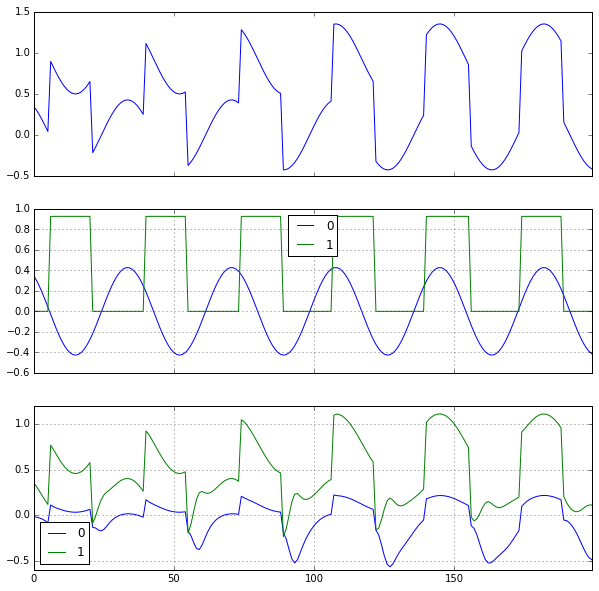

In [37]:
plot_sample(2)